In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('/content/heart_disease_uci.csv')


# **Data Cleaning**

# Handle Inappropriate Zeros

In [3]:
cols = ['trestbps', 'chol']
df[cols] = df[cols].replace(0, np.nan)

# Fill in missing values

In [4]:
# for numeric columns: we use median values to fill (impute) missing value

numeric_columns = ['trestbps', 'chol', 'thalch', 'oldpeak']
numeric_imputer = SimpleImputer(strategy='median')
df[numeric_columns] = numeric_imputer.fit_transform(df[numeric_columns])

# for categoric values we use the most frequent values to fill missing data
categorical_columns = ['fbs', 'restecg', 'exang', 'slope', 'thal']
categorical_imputer = SimpleImputer(strategy='most_frequent')

df[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])

In [5]:
df.drop(['ca'], axis= 1, inplace= True)

In [6]:
df.isnull().sum()

id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
thal        0
num         0
dtype: int64

# Data Transform

**Label Encoding The Categorical Values**

In [7]:
columns_to_encode = ['thal', 'dataset', 'slope', 'sex', 'num', 'cp', 'restecg', 'fbs', 'exang']

label_encoders = {}

for col in columns_to_encode:
  # Create a new LabelEncoder
  le = LabelEncoder()

  # fit and transform the data
  df[col] = le.fit_transform(df[col])

  # store the encoder for Later
  label_encoders[col] = le



**Transform the numeric columns**

In [8]:
columns_to_scale = ['oldpeak', 'thalch', 'chol', 'trestbps', 'age']
min_max_scalers = {}

for col in columns_to_scale:
  scaler = MinMaxScaler()

  df[col] = scaler.fit_transform(df[[col]])

  min_max_scalers[col] = scaler

**Select only Necessary Values**

In [9]:
X = df.drop(['id', 'num'], axis = 1)

In [10]:
y_binary = df['num']

In [11]:
y_binary = y_binary.replace(2, 1)
y_binary = y_binary.replace(3,1)
y_binary = y_binary.replace(4,1)

**Splitting Data**

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, train_size=0.8)


# Train an ML classifier

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [14]:
model = RandomForestClassifier(random_state=42)

In [15]:
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.
On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.

In [16]:
y_pred = model.predict(X_test)

In [17]:
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of our Random Forest model: ', accuracy)

Accuracy of our Random Forest model:  0.8043478260869565


**Let's tune the hyper-parameters**

In [18]:
# perform grid search

model = RandomForestClassifier(random_state=42)

param_grid = {
    'max_depth' : [None, 5, 10],
    'n_estimators': [None, 10, 100, 1000],
    'min_samples_split': [None, 2, 5, 10],
    'min_samples_leaf': [None, 1, 2, 4]
}

# not showing output here for ease of reading.
# when practicing, you can set the verbose parameter like verbose=10 in the line below
# to see how gridsearch is going
grid_search = GridSearchCV(estimator=model, param_grid=param_grid)

grid_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
555 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ut

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_leaf': [None, 1, 2, 4],
                         'min_samples_split': [None, 2, 5, 10],
                         'n_estimators': [None, 10, 100, 1000]})

In [19]:
# get best score so far
best_score = grid_search.best_score_

print("Best Score: ", best_score)


Best Score:  0.8355855855855856


In [20]:
best_params = grid_search.best_params_

print("Best params: ", best_params)

Best params:  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [21]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("Tuned accuracy: ", accuracy)

Tuned accuracy:  0.8260869565217391


**Evaluate their Performances**

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.76      0.80        83
           1       0.82      0.88      0.85       101

    accuracy                           0.83       184
   macro avg       0.83      0.82      0.82       184
weighted avg       0.83      0.83      0.82       184



<Axes: >

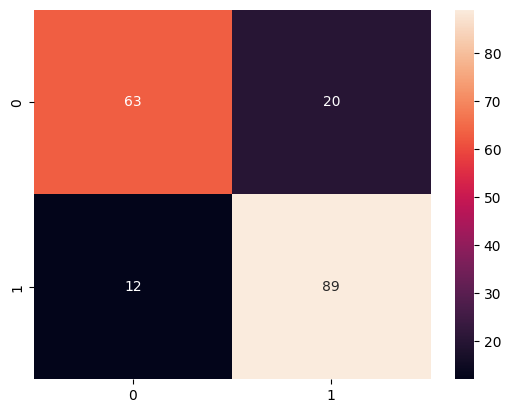

In [23]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot= True)

 **Model Selection**

In [24]:
models = [
    {
        'name':'Random Forest',
        'model':RandomForestClassifier(random_state=42)
    },
    {
        'name':'Logistic Regression',
        'model':LogisticRegression(random_state=42)
    },
    {
        'name': 'KNN',
        'model':KNeighborsClassifier()
    },
    {
        'name': 'XG Boost',
        'model':XGBClassifier(random_state= 42)
    },
    {
        'name': 'Support Vector Machine',
        'model':SVC(random_state=42)
    }
]

In [25]:
best_model = None
best_accuracy = 0.0

In [26]:
for model_dict in models:
  pipeline = Pipeline([
      ('model', model_dict['model'])
  ])

  pipeline.fit(X_train, y_train)

  y_pred = pipeline.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)

  print('Model', model_dict['name'])
  print('Test Accuracy', accuracy)
  print()

  if accuracy > best_accuracy:
    best_accuracy =  accuracy
    best_model = pipeline


print('Best Model', best_model)

Model Random Forest
Test Accuracy 0.8043478260869565

Model Logistic Regression
Test Accuracy 0.8152173913043478

Model KNN
Test Accuracy 0.8097826086956522

Model XG Boost
Test Accuracy 0.7717391304347826

Model Support Vector Machine
Test Accuracy 0.8152173913043478

Best Model Pipeline(steps=[('model', LogisticRegression(random_state=42))])


<Axes: >

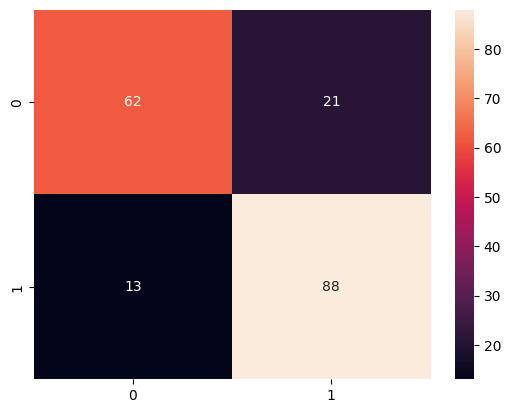

In [28]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)

In [30]:
# Perform grid search
for model_dict in models:
    model = model_dict['model']
    grid_params = {
        'max_depth': [None, 5, 10],
        'n_estimators': [None, 10, 100, 1000],
        'min_samples_split': [None, 2, 5, 10],
        'min_samples_leaf': [None, 1, 2, 4]
    }
    grid_search = GridSearchCV(estimator=model, param_grid=grid_params)
    grid_search.fit(X_train, y_train)

    print("Best parameters found for {}: {}".format(model.__class__.__name__, grid_search.best_params_))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
555 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ut

Best parameters found for RandomForestClassifier: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


ValueError: Invalid parameter 'max_depth' for estimator LogisticRegression(random_state=42). Valid parameters are: ['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'].